# Exploratory Data Analysis

In [2]:
from pickle import FALSE
import numpy as np
import pandas as pd
from IPython.core.pylabtools import figsize
from matplotlib import pyplot as plt
import seaborn as sns
from prometheus_client import Counter
from sklearn.utils import resample
from collections import Counter

from sklearn.utils.multiclass import class_distribution

## Load the data


In [3]:
df = pd.read_parquet('../data/processed/imputed_df.parquet')
df = df.dropna(subset=['target'])

df.head()

,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,NAME_TYPE_SUITE,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,...,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR,NAME_CONTRACT_TYPE_Revolving loans,CODE_GENDER_M,target,OCCUPATION_TYPE,CODE_GENDER,NAME_CONTRACT_TYPE
0,0.0,1.0,0.0,202500.0,406597.5,24700.5,351000.0,18.0,20.0,Secondary / secondary special,...,0.0,0.0,0.0,1.0,0.0,1.0,1.0,Laborers,M,Cash loans
1,0.0,0.0,0.0,270000.0,1293502.5,35698.5,1129500.0,6.0,10.0,Higher education,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Core staff,F,Cash loans
2,1.0,1.0,0.0,67500.0,135000.0,6750.0,135000.0,16.0,17.0,Secondary / secondary special,...,0.0,0.0,0.0,0.0,1.0,1.0,0.0,Laborers,M,Revolving loans
3,0.0,1.0,0.0,135000.0,312682.5,29686.5,297000.0,20.0,16.0,Secondary / secondary special,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Laborers,F,Cash loans
4,0.0,1.0,0.0,121500.0,513000.0,21865.5,513000.0,16.0,17.0,Secondary / secondary special,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,Core staff,M,Cash loans


## Featuring Distributions 


#### Numerical Distribution

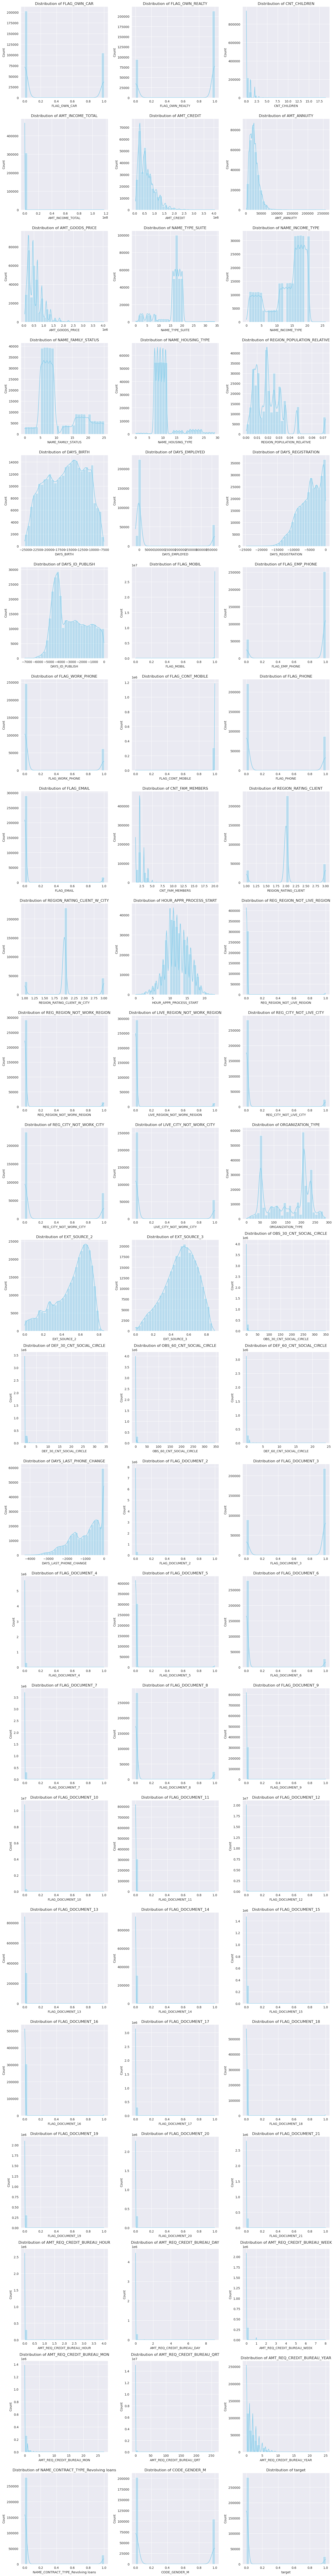

In [4]:
#Select numerical columns 
nColumns = df.select_dtypes(include= ['float64', 'int64']).columns
#Visulize distributions of numerical columns in histograms 
cols = 3
rows = int(np.ceil(len(nColumns)/cols))
plt.figure(figsize=(cols*5,rows*5))

for i, col in enumerate(nColumns,1):
    plt.subplot(rows,cols,i)
    #Histogram
    sns.histplot(df[col],kde=True, color= 'skyblue', bins= 30)
    #Boxplot for the outliers in color red 
    #sns.boxplot(x=df[col], color="red", width=0.2)
    
    plt.title(f'Distribution of {col}')
    
plt.tight_layout()
plt.show()

GRAPHS INTERPRETATION: 
After analyzing the distribution of the numerical columns, we get several relevant characteristics of the data, visualize in different graphs for a better interpretation. 

First focusing on the histogram represented in blue clor , we appreciate that most variables display varied distribution and the KDE provide a clearer view of the shape of each distribution. Some ones approximate to normal distribution like the "Flag Own Car" column that shows a roughly normal distribution and the KDE line symmetrically centered around the mean. This variable appears balanced and may not need transformation, making it suitable for models that assume normality. However, there are some columns as the "CNT_Children" column that clearly shows a right-skewed distribution, where most of the values concentrated on the left side and a tail extending to the right. 

On the other hand, the red box plots show the presence of outliers in some columns. For example a column with significant outliers on both ends might be "Name Income Type" column which shows significant outliers on both ends. Models that use distance calculations could be impacted, so we must consider outlier treatment or robust methods 

#### Categorical Distribution: 


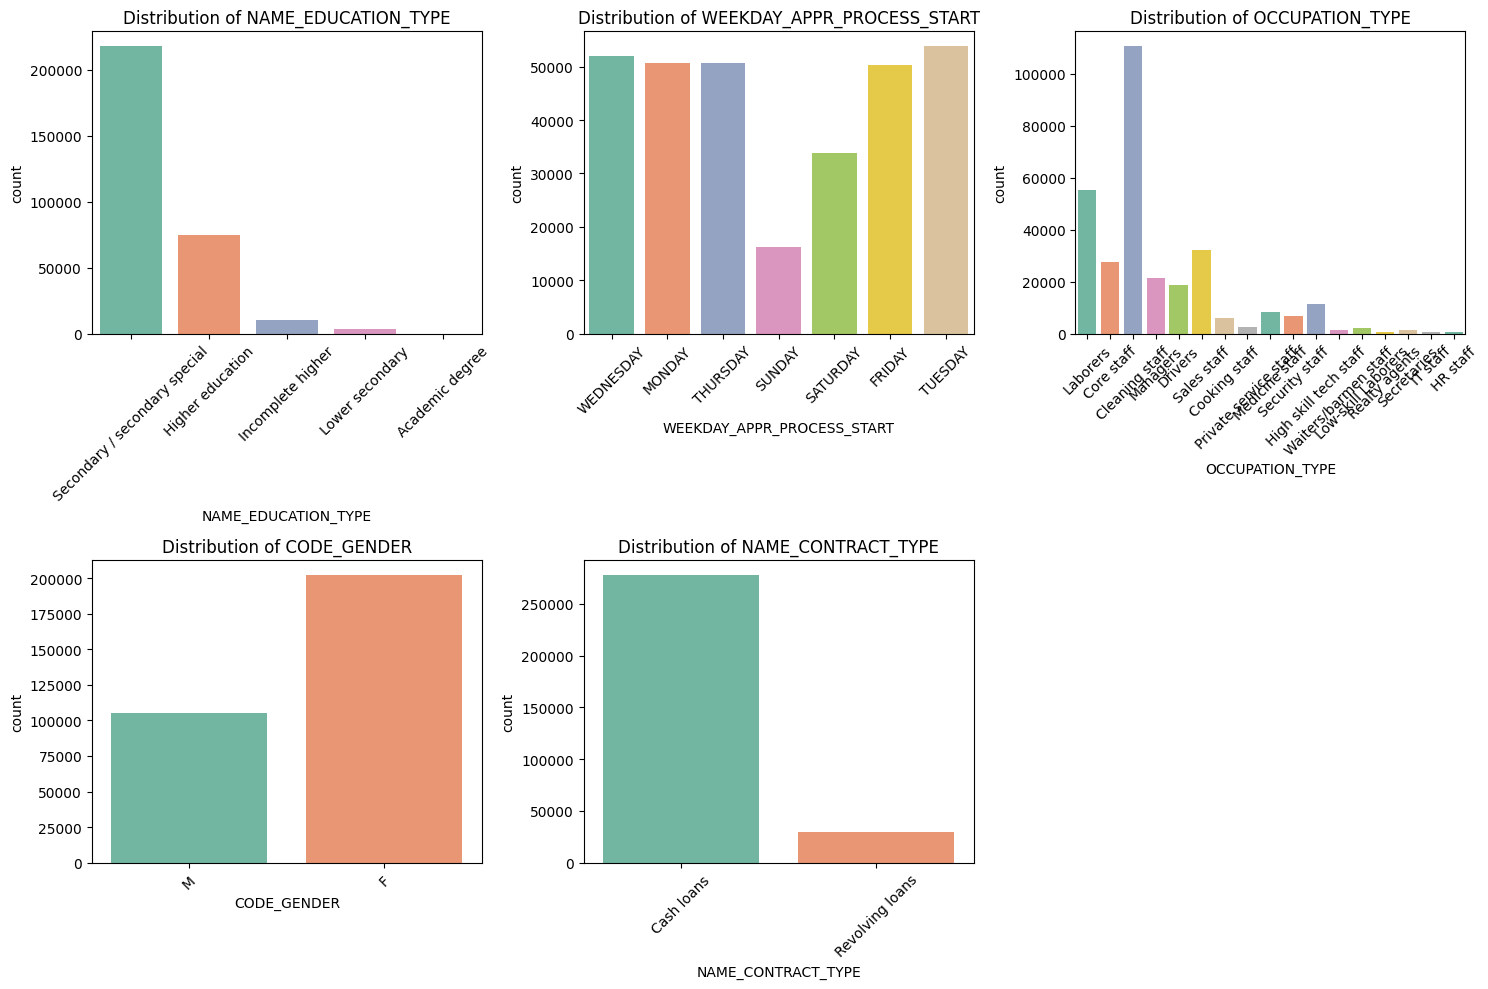

In [34]:
#SELECT CATEGORICAL COLUMNS 
import warnings
warnings.filterwarnings("ignore")

cColumns= df.select_dtypes(include= ['object', 'category']).columns

#Visulization 
cols= 3
rows= int(np.ceil(len(cColumns)/cols))
plt.figure(figsize= (cols*5,rows*5))
for i, feature in enumerate(cColumns):
    plt.subplot(rows, cols, i+1)
    sns.countplot(data= df, x= feature, palette="Set2")
    plt.title(f'Distribution of {feature}')
    plt.xticks(rotation= 45)
plt.tight_layout()
plt.show()

GRAPH INTERPRETATION:
The analysis of categorical distributions reveals important aspects of the dataset. 
Variables like, "NAME_EDUCATION TYPE", "OCCUPATION TYPE" and "CODE_GENDER" show clear imbalances, so addressing these imbalances will be necessary in modeling if this features contribute to the prediction.

Also we appreciate patterns in application behaviour, the weekly  distribution of "WEEKDAY_APPR_PROCESS_START" highlights certain days with higher activity, which could be relevant for operational insights. 

In "NAME_CONTRACT_TYPE" graph we appreciate a heavy focus on cash loans what suggested that the dataset is specific to certain types of financial needs, which should be considered when interpreting model results or applying insights to other loan types 

### CLASS BALANCE 

We will analysis the class balance based on the target of this project, which indicates whether an application has encountered payment difficulties in the past. A value of 0 will mean no payment difficulties and a value of 1 means there have been payment difficulties

Class count in TARGET:
 target
0.0    282679
1.0     24824
Name: count, dtype: int64


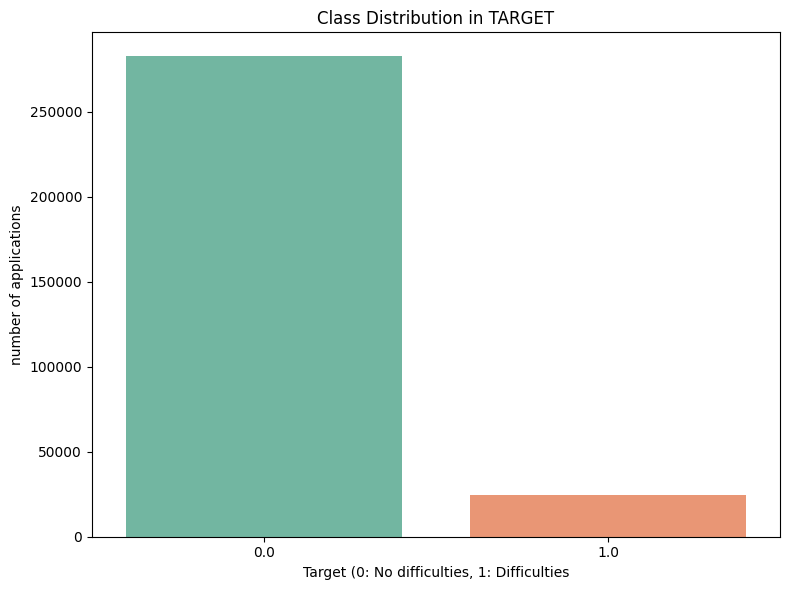

In [45]:

#VERIFY CLASS BALANCE 
class_distribution = df["target"].value_counts()
print("Class count in TARGET:\n", class_distribution)
 
#Visulize class distribution 
plt.figure(figsize= (8,6))
sns.countplot(x='target', data = df, palette= "Set2")
plt.title('Class Distribution in TARGET')
plt.xlabel('Target (0: No difficulties, 1: Difficulties')
plt.ylabel('number of applications')
plt.tight_layout()
plt.show()




In this graph we observe that exists a clear class imbalance in the target variable, where the majority class 0- 'No Difficulties' has a much larger account than the minority class 1-'Difficulties'. This imbalance can obstruct model performance, as the model may be biased on predicting the majority class because of its dominance in the data 

After balance (UnderSampling): 
Counter({0.0: 24824, 1.0: 24824})


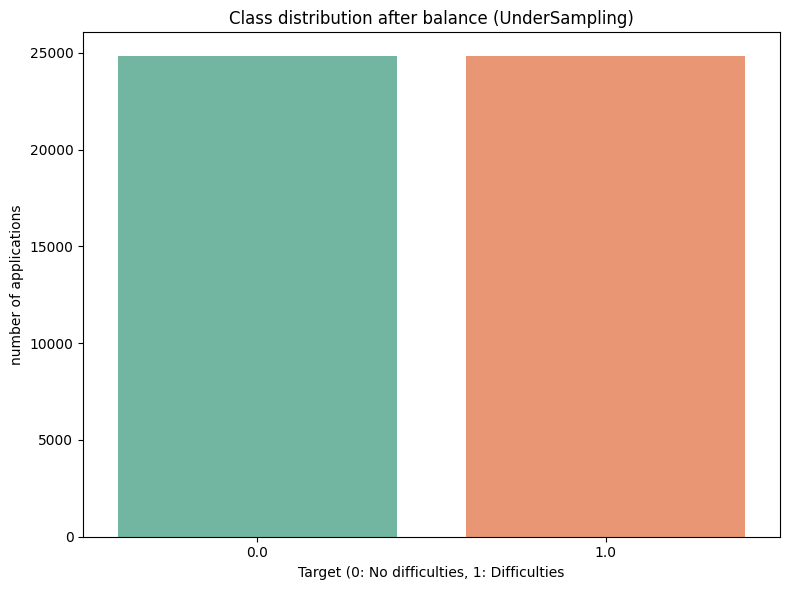

In [58]:
#CLASS BALANCE : UnderSumpling reducing majority class
x = df.drop(columns=['target'])
y = df['target']
df_combined = pd.concat([x,y], axis=1)
majority = df_combined[df_combined['target']==0]
minority = df_combined[df_combined['target']==1]

#Subsampling majority class to match the minority class and find the balance 
majority_subsample = resample(majority, replace=False,
n_samples= len(minority), random_state= 42)
balance = pd.concat([majority_subsample, minority])

x_balanced = balance.drop(columns=['target'])
y_balanced = balance['target']

print("After balance (UnderSampling): ")
print(Counter(y_balanced))

plt.figure(figsize= (8,6))
sns.countplot(x= y_balanced, palette= "Set2")
plt.title('Class distribution after balance (UnderSampling)')
plt.xlabel('Target (0: No difficulties, 1: Difficulties')
plt.ylabel('number of applications')
plt.tight_layout()
plt.show()

After class balancing using undersampling where we divide majority an minority classes, we see that the class distribution is now balanced, with both the "No difficulties" and "Difficulties" classes represent equally. This adjustment ensures that the model will treat both classes with the same importance 

In conlusion, the balanced class distribution achieved will improve the model´s ability to detect cases of "Difficulties" without overwhelming bias toward the "No difficulties" class. Also we must take into account that the applied undersampling might reduces the total data available for training, which could affect model accuracy. 

## Denoising data

Identify columns with potential noise or outliers

In [175]:
outliers = {}
numeric_cols = df.select_dtypes(include=['float64', 'int64']).columns

for col in numeric_cols:
    Q1 = df[col].quantile(0.25)
    Q3 = df[col].quantile(0.75)
    IQR = Q3-Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    outliers[col] = ((df[col] < lower_bound) | (df[col] > upper_bound)).sum()

sorted_outliers = sorted(outliers.items(), key = lambda x :x[1], reverse = True)
top_outliers_cols = [col for col, count in sorted_outliers if count > 0]
print("Columns with outliers:\n")
for i in range(0, len(top_outliers_cols)):
    print("Column: ", top_outliers_cols[i], "|\tNumber of outliers: ", outliers[top_outliers_cols[i]], "\n")


Columns with outliers:

Column:  REGION_RATING_CLIENT |	Number of outliers:  80525 

Column:  REGION_RATING_CLIENT_W_CITY |	Number of outliers:  78025 

Column:  DAYS_EMPLOYED |	Number of outliers:  72215 

Column:  REG_CITY_NOT_WORK_CITY |	Number of outliers:  70866 

Column:  FLAG_WORK_PHONE |	Number of outliers:  61303 

Column:  FLAG_EMP_PHONE |	Number of outliers:  55385 

Column:  LIVE_CITY_NOT_WORK_CITY |	Number of outliers:  55214 

Column:  NAME_TYPE_SUITE |	Number of outliers:  50618 

Column:  AMT_REQ_CREDIT_BUREAU_QRT |	Number of outliers:  50574 

Column:  AMT_REQ_CREDIT_BUREAU_MON |	Number of outliers:  43758 

Column:  DEF_30_CNT_SOCIAL_CIRCLE |	Number of outliers:  35164 

Column:  NAME_CONTRACT_TYPE_Revolving loans |	Number of outliers:  29274 

Column:  NAME_HOUSING_TYPE |	Number of outliers:  28686 

Column:  FLAG_DOCUMENT_6 |	Number of outliers:  27077 

Column:  DEF_60_CNT_SOCIAL_CIRCLE |	Number of outliers:  25767 

Column:  FLAG_DOCUMENT_8 |	Number of outliers:  

Visualize the 10 columns containing most outliers with box plots

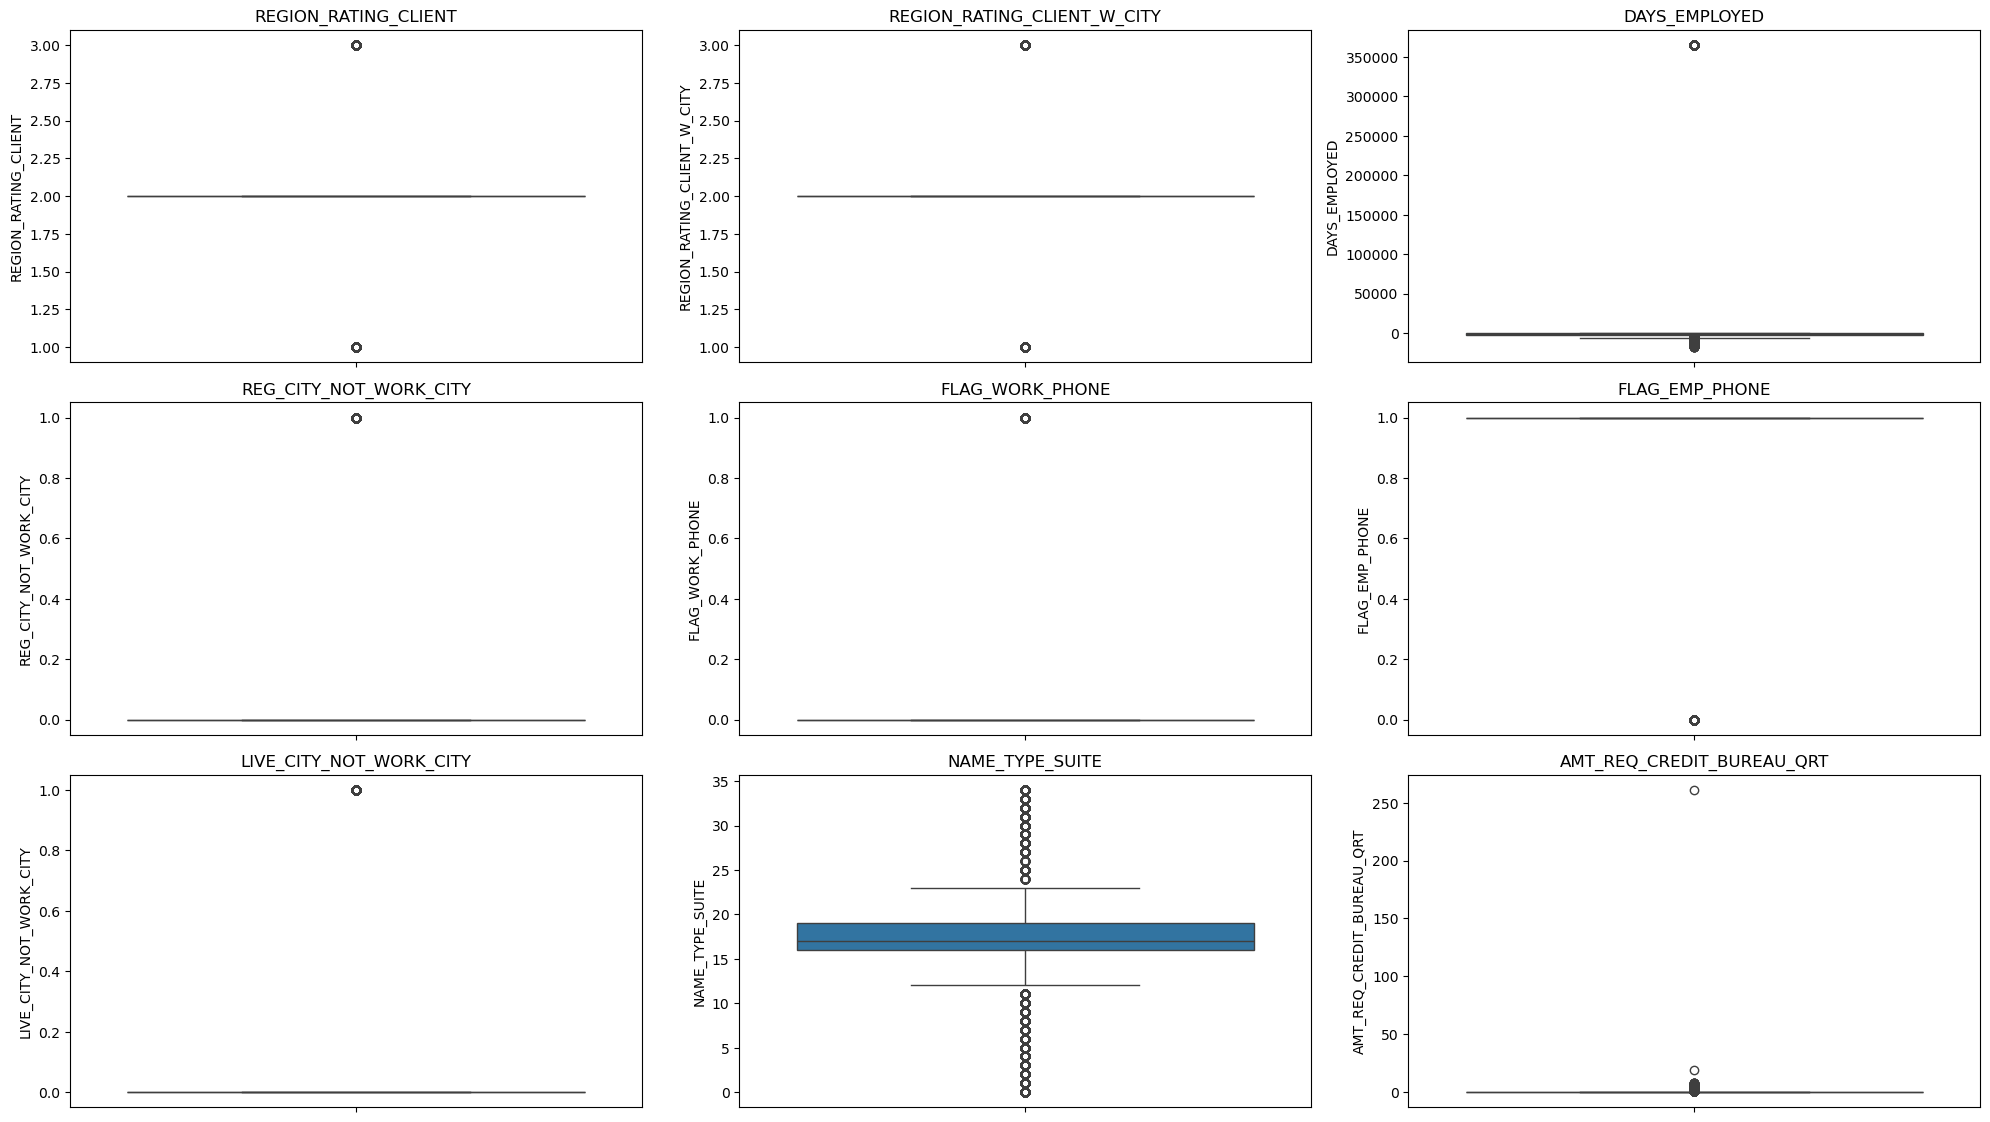

In [176]:
plt.figure(figsize=(20,15))
for i, col in enumerate(top_outliers_cols[:9]):
    plt.subplot(len(top_outliers_cols[:9]) // 3 +1, 3, i+1)
    sns.boxplot(y=df[col])
    plt.title(col)
    plt.tight_layout()

plt.show()

Denoise the identified columns replacing the outliers with the median

In [181]:
for col in top_outliers_cols:
    Q1 = df[col].quantile(0.25)
    Q3 = df[col].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    median = df[col].median()
    df[col] = df[col].apply(lambda x: median if x < lower_bound or x > upper_bound else x)

Plot the columns that had most outliers again to make sure that we have denoised them correctly

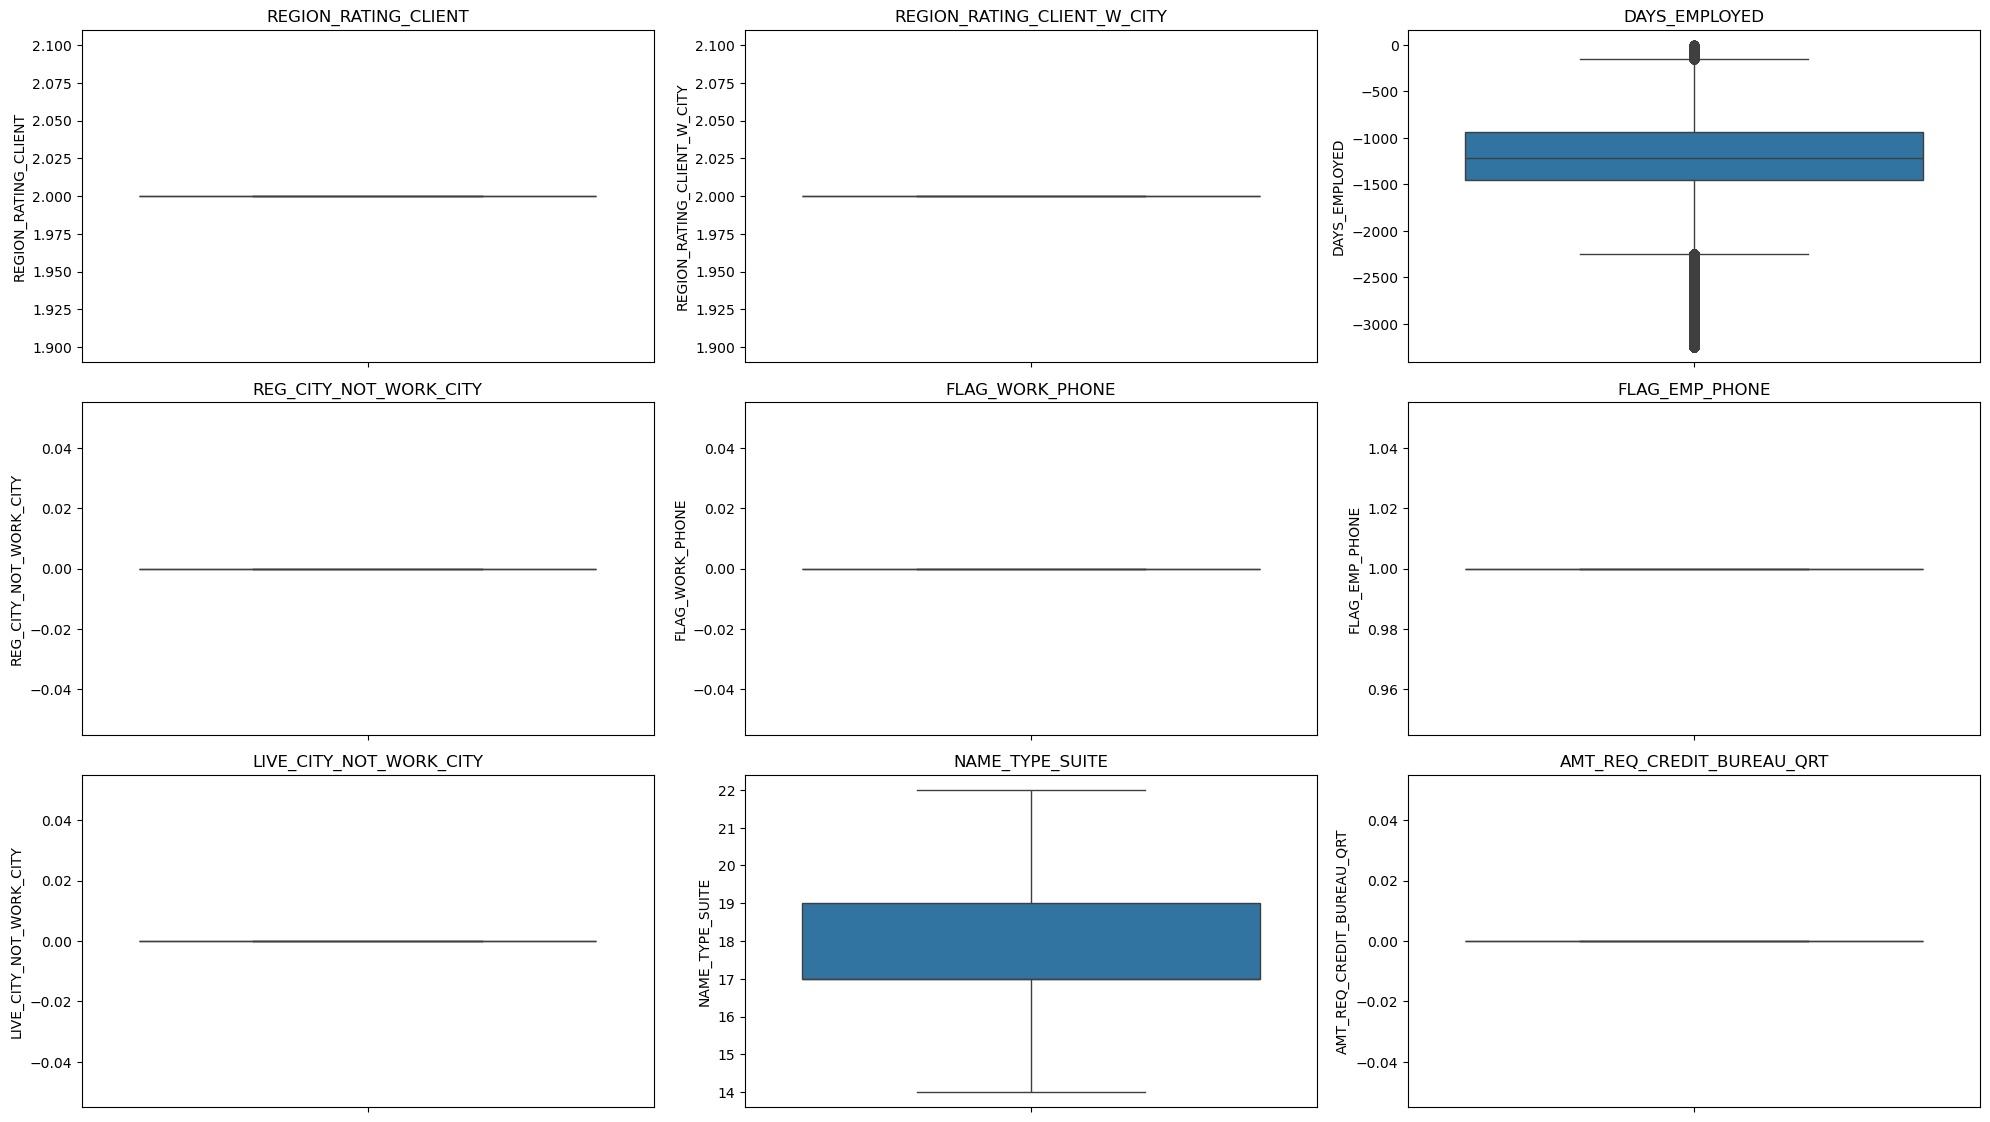

In [182]:
plt.figure(figsize=(20, 15))
for i, col in enumerate(top_outliers_cols[:9]):
    plt.subplot(len(top_outliers_cols[:9]) // 3 + 1, 3, i + 1)
    sns.boxplot(y=df[col])
    plt.title(col)
    plt.tight_layout()

plt.show()